# Lecture 21: Molecular Dynamics

CBIO (CSCI) 4835/6835: Introduction to Computational Biology

## Overview and Objectives

In the last lecture, we introduced the idea of computational structural biology and the concept of molecular dynamics simulations to gauge how proteins could move and perform their functions over different timescales. In this lecture, we'll go over some tools you can use (in Python, of course) to look at proteins and analyze MD trajectories. By the end of this lecture, you should be able to:

 - Download and explore PDB files of proteins using ProDy or PyMol
 - Understand the basics of performing PCA on covariance matrices of ensembles or trajectories
 - Use PyMol to visualize protein structures and interface with Python scripts

## Part 1: ProDy

<img src="Lecture21/prody-logo.png" />

ProDy stands for **Pro**tein **Dy**namics,

 - an API that is very suitable for interactive usage 
 - comes with several command line applications

ProDy is designed for normal mode analysis, but also is

 - a powerful tool for handling macromolecular structures
 - useful for analysis of molecular dynamics (MD) trajectories
 - useful for sequence conservation and coevolution analysis ([*Evol*](http://prody.csb.pitt.edu/evol/))

What is "normal mode analysis"?

From Bahar *et al* 2009, [*Normal Mode Analysis of Biomolecular Structures: Functional Mechanisms of Membrane Proteins*](http://pubs.acs.org/doi/abs/10.1021/cr900095e) (section 1.1.3):

    Normal mode analysis provides information on the equilibrium modes accessible to a system, assuming that the system is stabilized by harmonic potentials. It has been used for several decades in studying classical physical phenomena such as atomic vibrational spectra and transport in the solid state. Its application to proteins dates back to the early 1980s. However, only in the past decade has it become a tool widely used for exploring functional motions. A major reason behind its broader use is the observation that global modes elucidated by NMA bear functional significance. This feature became even more evident with the use of simplified models in coarse-grained (CG) NMA.

One way to look at it: what are the energetically-favorable configurations of a macromolecule?

These folded configurations of the protein(s) **have functional significance**, so it's very important to understand

 1. what the folded configurations are, and
 2. how the protein reaches those configurations

### ProDy basics

It's easy enough to get started: just import the base package.

In [1]:
import prody as pd  # Note: if you're a Pandas user, it has the same conventional abbreviation "pd", so be careful

Most ProDy functions follow a specific naming convention:

 - an action verb, followed by
 - some kind of three-letter abbreviation of an object

For example, a function that "does something" would be named in ProDy as **`doSTH`**

Just a few examples directly from the ProDy package:

  * `parseEXT()`: parse a file in EXT format, e.g. `parsePDB`, `parseDCD`
  * `writeEXT()`: write a file in EXT format, e.g. `writePDB`, `writeDCD`
  * `fetchSTH()`: download a file, e.g. `fetchPDB`, `fetchMSA`
  * `calcSTH()`: calculate something, e.g. `calcRMSD`, `calcGyradius`, `calcANM`
  * `showSTH()`: show a plotting of something, e.g. `showCrossCorrelations`, `showProtein`
  * `saveSTH()`: save a ProDy object instance to disk, e.g. `saveAtoms`
  * `loadSTH()`: save a ProDy object instance to disk, e.g. `loadAtoms`

We'll touch on a few of these.

Let's dive in with an example, shall we?

One of the coolest things about ProDy--when you request the structure information for a specific macromolecule, it will download that structure directly from the Protein Data Bank (remember PDB?):

In [2]:
ubi = pd.parsePDB("1ubi")

@> PDB file is found in working directory (1ubi.pdb.gz).
@> 683 atoms and 1 coordinate set(s) were parsed in 0.01s.


How cool is that?!

### PDB

Recall from our last lecture: the Protein Data Bank is a website ( www.rcsb.org/pdb/home/home.do ), but the acronym **PDB** is the file format used by the website (and pretty much any researcher interested in protein structure) to describe the 3D structures of macromolecules.

<img src="Lecture21/pdb-logo.png" />

Each macromolecule on the PDB is given a 4-digit descriptor; usually the first digit is a number, and the next three are letters related to the name of the protein.

In our code example, we used `1ubi`.

<img src="Lecture21/1ubi-landing.png" width="80%" />

Note the wealth of information presented about this chromosomal protein--this even excludes all the literature hits below that cite the use of this macromolecule.

Also note the "Download Files" link in the upper right--this is where you can get the PDB files if you don't already have them.

On the other hand, if you're using ProDy, it will just download them for you!

Back to ProDy! Since it went ahead and downloaded the PDB file for `1ubi` for us, let's take a look at what we have.

In [3]:
print(ubi)

AtomGroup 1ubi


In [4]:
print(ubi.numAtoms())

683


In [5]:
print(pd.calcGyradius(ubi))  # This function calculates the radius of gyration of the atoms

12.085104173


### File Handling

If the internet isn't your thing, ProDy has its own formats for interacting with files on your hard drive.

In [6]:
pd.saveAtoms(ubi)

'1ubi.ag.npz'

You can also save to and load from more standard file formats, like PDB:

In [7]:
pd.writePDB("ubi.pdb", ubi)  # Save to the file "ubi.pdb"

'ubi.pdb'

In [8]:
ubi2 = pd.parsePDB("ubi.pdb")  # Now read from it, just to test that it worked!
print(ubi2)

@> 683 atoms and 1 coordinate set(s) were parsed in 0.00s.


AtomGroup ubi


The key point: if the argument you specify to `parsePDB` doesn't exist on your computer, then it'll connect to PDB directly to try and download it.

Note the *type* of the variable that comes back from a call to `parsePDB`:

In [9]:
type(ubi)

prody.atomic.atomgroup.AtomGroup

Why `AtomGroup`?

 - not `Molecule`, because structures are usually made up from multiple molecules
 - not `Structure`, because PDB format is sometimes used for storing small-molecules
  
`AtomGroup` made sense for handling bunch of atoms, and is used by some other packages too.

### Some `AtomGroup` methods

As we've seen, we can check on how many atoms there are:

In [10]:
print(ubi.numAtoms())

683


In [11]:
ag = pd.parsePDB('1vrt')
print(ag.numAtoms())

@> PDB file is found in working directory (1vrt.pdb.gz).
@> 7953 atoms and 1 coordinate set(s) were parsed in 0.09s.


7953


We can also ask for specific properties of the macromolecule.

In [12]:
names = ag.getNames()
print(names)

['N' 'CA' 'C' ..., 'O' 'O' 'O']


What do you think these are?

In [13]:
len(names)

7953

In [14]:
type(names)

numpy.ndarray

Oh hey, we recognize that!

We could ask for more detail on the macromolecule, such as its location in space:

In [15]:
coords = ag.getCoords()
print(coords)

[[ 15.287 -59.293  35.335]
 [ 15.16  -58.082  36.18 ]
 [ 15.828 -56.998  35.357]
 ..., 
 [ 33.12   -9.865  17.954]
 [ 34.519 -12.765  19.01 ]
 [ 45.687  -3.841  -0.901]]


In [16]:
print(coords.shape)

(7953, 3)


(Would you be able to compute the generalized coordinates of this macromolecule?)

### `Atom` instances

You can get the names of all the atoms in the macromolecule via the `getNames` method, but you can also index the macromolecule *directly* as though it were an array:

In [17]:
a0 = ag[0]
print(a0)

Atom N (index 0)


In [18]:
print(a0.getName())

N


Taking that same thinking further, we can even slice out subgroups of atoms from the macromolecule:

In [19]:
every_other_atom = ag[::2]
print(every_other_atom)

Selection 'index 0:7953:2'


The type is a `Selection` object, but we can see that we get what we'd expect:

In [20]:
print(len(every_other_atom))
print(len(ag))

3977
7953


### ProDy Hierarchy

Atoms, structures, residues... all terms we understand from a biological perspective, but how do they play into ProDy?

ProDy arranges these concepts into a hierarchy within a macromolecule. The hierarchy looks something like this:

 - `Atom`: lowest level of the hierarchy
 - Residue: an amino acid, nucleotide, small molecule, or ion
 - Chain: a polypeptide or nucleic acid chain
 - Segment: used by simulation programs and comprise multiple chains

In [21]:
print(ag.numChains())

2


In [22]:
print(ag.numResidues())

1233


We can set up a loop to iterate through the chains, using the `iterChains` method:

In [23]:
# Printing out each chain and the number of residues each has.
for chain in ag.iterChains():
    print(chain, chain.numResidues())

Chain A 688
Chain B 545


In [24]:
# Here, we'll print out each chain and their first 10 residues.
for chain in ag.iterChains():
    print(chain)
    residues = 0
    for residue in chain:  # We can also loop through residues on a chain!
        print(' | - ', residue)
        residues += 1
        if residues >= 10: break
    print("...")

Chain A
 | -  PRO 4
 | -  ILE 5
 | -  GLU 6
 | -  THR 7
 | -  VAL 8
 | -  PRO 9
 | -  VAL 10
 | -  LYS 11
 | -  LEU 12
 | -  LYS 13
...
Chain B
 | -  ILE 5
 | -  GLU 6
 | -  THR 7
 | -  VAL 8
 | -  PRO 9
 | -  VAL 10
 | -  LYS 11
 | -  LEU 12
 | -  LYS 13
 | -  PRO 14
...


Other methods for looping over structures in a macromolecule:

 - `iterAtoms`
 - `iterBonds`
 - `iterCoordsets`
 - `iterFragments`
 - `iterSegments`

**Two time-saving asides:**

 1. In Jupyter, you can TAB-complete with partial function names to see the list of all the functions available to you.
 2. Also in Jupyter, you can type out a function name, but at the end, put a question mark `?` and hit ENTER. This will bring up the documentation for how to use that function.

### Selection Grammar

This is a very complicated, but *very powerful*, interface to searching for specific properties of your molecule. We won't spend a lot of time here, but this basically allows you to search for specific atoms, residues, or chains using plain English:

In [25]:
# Select all the alpha Carbon atoms
sel = ag.select("protein and name CA")
print(sel)
print(sel.numAtoms())

Selection 'protein and name CA'
925


In [26]:
# Shorthand 
sel2 = ag.select("calpha")
sel3 = ag.select("ca")
sel2 == sel3

True

You can also select atoms or residues by proximity:

In [27]:
import numpy as np
origin = np.zeros(3)

sel = ag.select("within 5 of origin", origin = origin)
print(sel)
print(pd.calcDistance(sel, origin))

Selection 'index 3444 to 3445'
[ 4.04402732  4.18061778]


In [28]:
sel = ag.select("within 5 of center", center = pd.calcCenter(ag))
print(sel)

Selection 'index 4457 to 4...49 to 7353 7941'


In [29]:
# You can even use dot-selection shorthand, instead of the "select" method!
ag.calpha

<Selection: 'calpha' from 1vrt (925 atoms)>

In [30]:
ag.name_CA_and_resname_ALA

<Selection: 'name CA and resname ALA' from 1vrt (37 atoms)>

See the full documentation on selection grammar here: http://csb.pitt.edu/ProDy/reference/atomic/select.html

### Chain Matching and RMSD

ProDy will even try to find matching portions of chains in macromolecules, and align one macromolecule to another.

In [31]:
p38 = pd.parsePDB("5uoj")
bound = pd.parsePDB("1zz2")

matches = pd.matchChains(p38, bound)
print(len(matches))
p38_ch, bnd_ch, seqid, seqov = matches[0]

print(bnd_ch)
print(seqid)
print(seqov)

@> PDB file is found in working directory (5uoj.pdb.gz).
@> 3138 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> PDB file is found in working directory (1zz2.pdb.gz).
@> 2872 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> Checking AtomGroup 5uoj: 1 chains are identified
@> Checking AtomGroup 1zz2: 1 chains are identified
@> Trying to match chains based on residue numbers and names:
@>   Comparing Chain A from 5uoj (len=343) and Chain A from 1zz2 (len=337):
@> 	Match: 337 residues match with 99% sequence identity and 98% overlap.


1
AtomMap Chain A from 1zz2 -> Chain A from 5uoj
99.40652818991099
98.25072886297376


`matchChains` takes 2 arguments: two `AtomGroup` objects to compare.

It returns however many matches it finds (in our example, only 1).

Each returned match contains 4 values:

 1. the matching chain from the first argument
 2. the matching chain from the second argument
 3. percent identity of the match
 4. percent sequence overlap of the match

We can then use the matching chains from the two proteins to perform an *alignment*: finding a pose of one of the chains with respect to the other one.

Right now, even though these chains match, they don't align very well:

In [32]:
print(pd.calcRMSD(p38_ch, bnd_ch))

72.9356151792


Recall our discussion of [RMSD (Root Mean Squared Deviation)](https://en.wikipedia.org/wiki/Root-mean-square_deviation) from the previous lecture--it's basically the Euclidean distance between corresponding points in 3D space.

We have an alignment of these chains from the `matchChains` function, but they differ considerably in terms of their physical, spatial poses. Here, we want to ask if their structure--while similar, not identical--allows them to overlap even in space.

We can use the function `superpose` to create a *superposition* of these chains.
 - The first argument is considered the *mobile* chain
 - The second argument is considered the *target*, or fixed, chain

In [33]:
bnd_ch, transformation = pd.superpose(bnd_ch, p38_ch)
print(pd.calcRMSD(bnd_ch, p38_ch))

1.8248053285


Much better!

### Dynamics Analysis

ProDy can even perform some analysis of molecular dynamics.

PDB has some more complicated macromolecules that include several conformers of the same protein, called an *ensemble*. This is basically a fancy term for "set of molecules that are the same but in different spatial poses"--as in, what you'd get from the output of an MD simulation.

In [34]:
ubi = pd.parsePDB('2lz3')

@> PDB file is found in working directory (2lz3.pdb.gz).
@> 890 atoms and 21 coordinate set(s) were parsed in 0.08s.


**WARNING: There is a bug in ProDy.** Running this command on a PDB structure with *more than one component* (i.e., an ensemble of macromolecule models in a single file) will result in an error unless you use the version directly available through GitHub (or fix it yourself).

There are 21 conformers in this single file (PDB predicts there are 200 total for this molecule!). ProDy will recognize the ensemble nature, though, if we run the following:

In [35]:
ubi_ensemble = pd.Ensemble(ubi.calpha)  # Why calpha?
ubi_ensemble

<Ensemble: Selection 'calpha' (21 conformations; 56 atoms)>

The next step is to minimize the differences between each conformer.

In [36]:
print(ubi_ensemble.getRMSDs())

[  0.           0.57284285  11.2888741   11.30148863  11.41711493
  11.42144298  10.4172007   11.51701601  11.08908232  11.2744685
  12.12013664   8.95550005  11.33651164  11.56495638   1.3928204
   8.95476071  10.8293237    2.92029743   3.05175372   0.80874764
  11.09695638]


Initially, the conformers aren't aligned; their respective RMSDs to some reference (by default, the first one; hence its RMSD is 0) is decently high.

We can fix this with the `interpose` function:

In [37]:
ubi_ensemble.iterpose()  # This performs an iterative alignment.

print(ubi_ensemble.getRMSDs())  # Did that improve things any?

@> Starting iterative superposition:
@> Step #1: RMSD difference = 3.0662e-01
@> Step #2: RMSD difference = 1.1445e-03
@> Step #3: RMSD difference = 8.5349e-06
@> Iterative superposition completed in 0.04s.


[ 0.30724894  0.62161435  0.51387945  0.48827789  0.51220688  0.5098784
  0.7197639   0.48183284  0.65930875  0.67412375  0.72184456  0.58774651
  0.7169057   0.92771202  1.25304616  0.75040665  1.54425363  0.96984149
  0.92221827  0.66109219  0.67394524]


Once we've aligned the conformers, we can do some analysis. Remember PCA?

In [38]:
pca = pd.PCA()

pca.buildCovariance(ubi_ensemble)
cov = pca.getCovariance()
print(cov.shape)

@> Covariance is calculated using 21 coordinate sets.
@> Covariance matrix calculated in 0.002974s.


(168, 168)


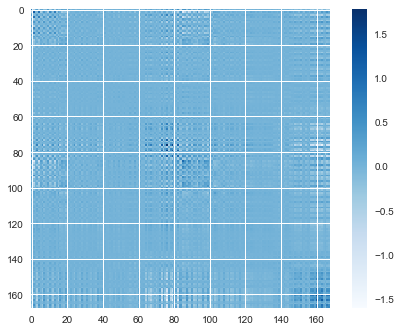

In [39]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

plt.imshow(cov, cmap = 'Blues')
plt.colorbar()

Initial results don't tell us a whole lot, except that there seem to be some parts of the ensemble that are positively correlated, and some negatively correlated. Let's dig in a bit more.

In [40]:
pca.calcModes()  # Performs the actual PCA analysis.

@> 20 modes were calculated in 0.01s.


Now that we've calculated the modes--or *principal components!*--we can see everything that we discussed in the previous lecture.

For starters, let's look at the eigenvalues.

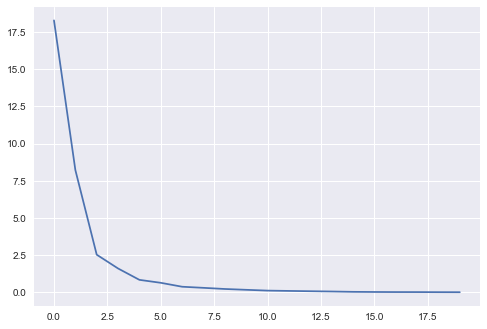

In [41]:
plt.plot(pca.getEigvals())

Remember what we said about how PCA works: it rotates the data such that each dimension / axis of the data contains a certain amount of the original *variance*.

PCA then returns to us the new axes of the data (as the eigenvectors), and the relative contributions (or importance) of each axis to the data (as the eigenvalues).

Therefore, rather than retain all the data, we can just keep the top handful of dimensions, as specified by the eigenvalues--which quantify precisely how much each dimension "counts".

In [42]:
for mode in pca:
    print(pd.calcFractVariance(mode).round(2))

0.54
0.25
0.08
0.05
0.02
0.02
0.01
0.01
0.01
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


 - The first dimension *alone* contains over half the variance in the original data.
 - Include the second dimension, and you already have nearly 80% of the original variance.
 - With just the *first four dimensions*, you have nearly 95% of the original variance with but a tiny fraction of the original quantity of data.

Put another way, **these first four modes explain 95% of the motion observed in the molecular ensemble**. Unless you're interested in really super-high frequency movement, this will probably be sufficient for future analyses.

We can also use the eigenvectors that were computed to look at the fluctuations in each atom.

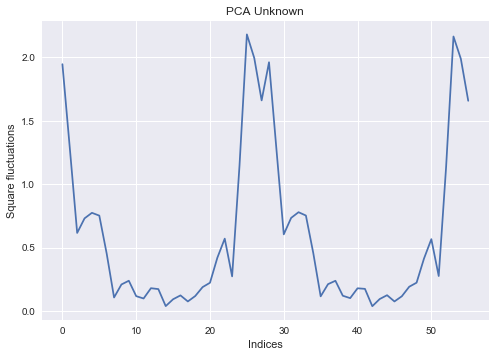

In [43]:
pd.showSqFlucts(pca)

Of the nearly-60 atoms in the chains, the atoms around certain indices move quite a bit more than the others.

ProDy even comes with a neat projection visualization to view RMSDs for each mode.

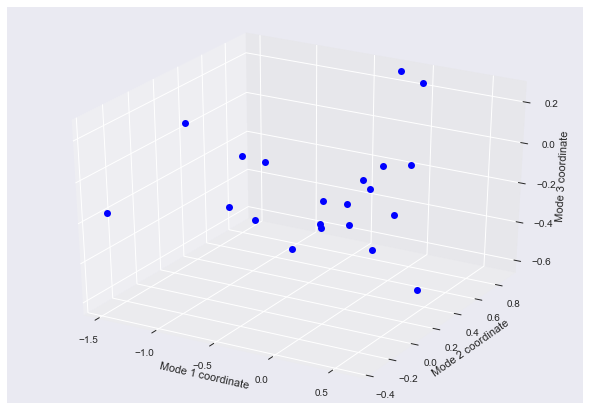

In [44]:
pd.showProjection(ubi_ensemble, pca[:3])  # The first 3 principal components

## This is all great, but...

I want to actually *generate* MD simulation data!

Well, ProDy isn't really for that. However, quite a few other tools are:

Amber [http://ambermd.org](http://ambermd.org)

* Very fast GPU implementation

Gromacs [http://www.gromacs.org](http://www.gromacs.org)

* Open-source (LGPL)

NAMD [http://www.ks.uiuc.edu/Research/namd/](http://www.ks.uiuc.edu/Research/namd/)

* Highly optimized for cluster computing
* Integrated with VMD

LAMMPS [http://lammps.sandia.gov](http://lammps.sandia.gov)

* Open-source (GPL)

MDAnalysis [http://www.mdanalysis.org/](http://www.mdanalysis.org/)

 - Very easy to get up and running; tight integration with NumPy
 - Similar naming conventions to ProDy
 - For analysis of MD trajectories

## Part 2: PyMol

PyMol: open source, crazy-awesome, but UNFORTUNATELY NOT FREE molecular viewing tool.

<img src="Lecture21/pymol-logo.png" />

(though they do have an educational version that's *almost* as good, and is free--I encourage you to download this and play around with it)

[demo]

## Administrivia

 - Assignment 4 out today, come heck or high water.

 - Next week: bioimaging!

## Additional Resources



 - ProDy http://prody.csb.pitt.edu/
 - PyMol for Beginners https://pymolwiki.org/index.php/Practical_Pymol_for_Beginners
 - PyMol cheat sheet http://pymolwiki.org/index.php/CheatSheet 
 - Protein Data Bank http://www.rcsb.org/pdb/home/home.do